In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%run get_odds.py
%run Helper.py

In [3]:
class league_bru():
    def __init__(self, teams=None, p_alpha=None, q_alpha=None, alpha_hat=None, p_beta=None, q_beta=None, beta_hat=None,
                p_gamma=None, q_gamma=None, gamma_hat=None, w=0.9879 , w_b=0.77767, w3=0.9984992, delta=10, 
                 delta_g=713.4048222, 
                 promoted=dict({'p_alpha':44.28, 'q_alpha':53.71, 'p_beta':43.43, 'q_beta':39.29, 
                           'p_gamma':1.4*713.4048222, 'q_gamma':713.4048222}), 
                 relegated=dict({'p_alpha':53.71, 'q_alpha':44.28, 'p_beta':39.29, 'q_beta':43.43, 
                           'p_gamma':1.4*713.4048222, 'q_gamma':713.4048222}), trained_data=pd.DataFrame()):
        self.teams = teams
        if self.teams:
            self.NT = len(teams)
        self.p_alpha = p_alpha
        self.q_alpha = q_alpha
        self.alpha_hat = alpha_hat
        self.p_beta = p_beta
        self.q_beta = q_beta
        self.beta_hat = beta_hat
        self.p_gamma = p_gamma
        self.q_gamma = q_gamma
        self.gamma_hat = gamma_hat
        self.w = w
        self.w3 = w3
        self.w_b = w_b
        self.delta = delta
        self.delta_g = delta_g
        self.promoted = promoted
        self.relegated = relegated
        self.trained_data = trained_data
    
    def initialise(self, teams):
        self.teams = teams
        self.NT = len(teams)
        self.p_alpha = np.array([self.delta]*self.NT, dtype=float)
        self.q_alpha = np.array([self.delta]*self.NT, dtype=float)
        self.alpha_hat = (self.p_alpha)/self.q_alpha
        
        self.p_beta = np.array([self.delta]*self.NT, dtype=float)
        self.q_beta = np.array([self.delta]*self.NT, dtype=float)
        self.beta_hat = self.p_beta/self.q_beta
        
        self.p_gamma = np.array([1.45*self.delta_g]*self.NT, dtype=float)
        self.q_gamma = np.array([self.delta_g]*self.NT, dtype=float)
        self.gamma_hat = (self.p_gamma-1)/self.q_gamma
    
    def train(self, data):
        data.loc[data['FTHG'] > 5, 'FTHG'] = 5
        data.loc[data['FTAG'] > 5, 'FTAG'] = 5
        
        data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
        
        lambdasH = []
        lambdasA = []
        p_alphasH = []
        q_alphasH = []
        p_betasH = []
        q_betasH = []
        p_gammasH = []
        q_gammasH = []
        p_alphasA = []
        q_alphasA = []
        p_betasA = []
        q_betasA = []
        p_gammasA = []
        q_gammasA = []
        # iterate through data
        for i in range(data.shape[0]):
            match = data.iloc[[i]]
            # get indices of home and away sides
            HT = int(np.arange(self.NT)[self.teams==match.iloc[0].loc['HomeTeam']])
            AT = int(np.arange(self.NT)[self.teams==match.iloc[0].loc['AwayTeam']])
            # get home and away lambda
            lambdaH = self.alpha_hat[HT]*self.beta_hat[AT]*self.gamma_hat[HT]
            lambdasH.append(lambdaH)
            
            lambdaA = self.alpha_hat[AT]*self.beta_hat[HT]
            lambdasA.append(lambdaA)
            # store home and away p and q parameters for distribution tracking and analysis
            p_alphasH.append(self.p_alpha[HT])
            q_alphasH.append(self.q_alpha[HT])
            p_betasH.append(self.p_beta[HT])
            q_betasH.append(self.q_beta[HT])
            p_gammasH.append(self.p_gamma[HT])
            q_gammasH.append(self.q_gamma[HT])
            p_alphasA.append(self.p_alpha[AT])
            q_alphasA.append(self.q_alpha[AT])
            p_betasA.append(self.p_beta[AT])
            q_betasA.append(self.q_beta[AT])
            p_gammasA.append(self.p_gamma[AT])
            q_gammasA.append(self.q_gamma[AT]) 
            
            X = int(match['FTHG'])
            Y = int(match['FTAG'])
            
            self.p_alpha[HT] = self.w*self.p_alpha[HT]+X
            self.q_alpha[HT] = self.w*self.q_alpha[HT]+self.beta_hat[AT]*self.gamma_hat[HT]
            self.alpha_hat[HT] = (self.p_alpha[HT]-1)/self.q_alpha[HT]

            self.p_alpha[AT] = self.w*self.p_alpha[AT]+Y
            self.q_alpha[AT] = self.w*self.q_alpha[AT]+self.beta_hat[HT]
            self.alpha_hat[AT] = (self.p_alpha[AT]-1)/self.q_alpha[AT]

            self.p_beta[HT] = self.w*self.p_beta[HT]+Y
            self.q_beta[HT] = self.w*self.q_beta[HT]+self.alpha_hat[AT]
            self.beta_hat[HT] = (self.p_beta[HT]-1)/self.q_beta[HT]

            self.p_beta[AT] = self.w*self.p_beta[AT]+X
            self.q_beta[AT] = self.w*self.q_beta[AT]+self.alpha_hat[HT]*self.gamma_hat[HT]
            self.beta_hat[AT] = (self.p_beta[AT]-1)/self.q_beta[AT]

            self.p_gamma[HT] = self.w3*self.p_gamma[HT]+X
            self.q_gamma[HT] = self.w3*self.q_gamma[HT]+self.alpha_hat[HT]*self.beta_hat[AT]
            self.gamma_hat[HT] = (self.p_gamma[HT]-1)/self.q_gamma[HT]
        
        phome = 1 - skellam.cdf(0, lambdasH, lambdasA)
        pdraw = skellam.pmf(0, lambdasH, lambdasA)
        paway = 1-phome-pdraw
        P = np.zeros((len(data), 3))
        P[:,0] = phome
        P[:,1] = pdraw
        P[:,2] = paway
        Z = FTRtoZ(data['FTR'])
        data['BS'] = BS(Z, P)
        #data['LS'] = LS(Z, P)
        data['PHome'] = phome
        data['PDraw'] = pdraw
        data['PAway'] = paway
        data['LambdaH'] = lambdasH
        data['LambdaA'] = lambdasA
        
        data['p_alpha_home'] = p_alphasH
        data['p_beta_home'] = p_betasH
        data['p_gamma_home'] = p_gammasH
        data['q_alpha_home'] = q_alphasH
        data['q_beta_home'] = q_betasH
        data['q_gamma_home'] = q_gammasH
        
        data['p_alpha_away'] = p_alphasA
        data['p_beta_away'] = p_betasA
        data['p_gamma_away'] = p_gammasA
        data['q_alpha_away'] = q_alphasA
        data['q_beta_away'] = q_betasA
        data['q_gamma_away'] = q_gammasA
        
        self.trained_data = self.trained_data.append(data, ignore_index=True) 

    def predict(self, HomeTeam, AwayTeam):
        HT = int(np.arange(self.NT)[self.teams==HomeTeam])
        AT = int(np.arange(self.NT)[self.teams==AwayTeam])
        LambdaH = self.alpha_hat[HT]*self.beta_hat[AT]*self.gamma_hat[HT]
        LambdaA = self.alpha_hat[AT]*self.beta_hat[HT]
        
        home_goals = np.zeros(9)
        away_goals = np.zeros(9)
        for i in range(8):
            home_goals[i] = poisson.pmf(i, LambdaH)
            away_goals[i] = poisson.pmf(i, LambdaA)
        home_goals[8] = 1-sum(home_goals)
        away_goals[8] = 1-sum(away_goals)
        scores = np.zeros((9,9))
        for i in range(9):
            for j in range(9):
                scores[i,j] = home_goals[i]*away_goals[j]
        
        phome = np.tril(scores, -1).sum()
        pdraw = sum(np.diag(scores))
        paway = np.triu(scores, 1).sum()
        
        # most likely result
        result = np.where(scores==np.max(scores))
        result = list(result)
        ml_result = [int(result[0]), int(result[1])]
        
        return({'matrix':scores, 'outcomes':[phome, pdraw, paway], 'result':ml_result})
    
    def predict_lambdas(self, LambdaH, LambdaA):
        home_goals = np.zeros(9)
        away_goals = np.zeros(9)
        for i in range(8):
            home_goals[i] = poisson.pmf(i, LambdaH)
            away_goals[i] = poisson.pmf(i, LambdaA)
        home_goals[8] = 1-sum(home_goals)
        away_goals[8] = 1-sum(away_goals)
        scores = np.zeros((9,9))
        for i in range(9):
            for j in range(9):
                scores[i,j] = home_goals[i]*away_goals[j]
        
        phome = np.tril(scores, -1).sum()
        pdraw = sum(np.diag(scores))
        paway = np.triu(scores, 1).sum()
        
        # most likely result
        result = np.where(scores==np.max(scores))
        result = list(result)
        ml_result = [int(result[0]), int(result[1])]
        
        return({'matrix':scores, 'outcomes':[phome, pdraw, paway], 'result':ml_result})
    
    def new_season(self, teams_out, teams_promoted_in, teams_relegated_in=None):
        # record variables belonging to each team
        tracker=dict({'teams':self.teams, 'p_alpha':self.p_alpha, 'q_alpha':self.q_alpha, 'p_beta':self.p_beta, 
                      'q_beta':self.q_beta, 'p_gamma':self.p_gamma, 'q_gamma':self.q_gamma})
        teams_df = pd.DataFrame(tracker)
        # remove teams existing league
        teams_out_index = []
        for i in range(len(self.teams)):
            if self.teams[i] in teams_out:
                teams_out_index.append(i)
        self.teams = np.delete(self.teams, teams_out_index)
        # add new teams to the league
        self.teams = np.append(self.teams, teams_promoted_in)
        if teams_relegated_in:
            self.teams = np.append(self.teams, teams_relegated_in)
        self.teams = np.array(sorted(self.teams))

        self.p_alpha = np.array([])
        self.q_alpha = np.array([])
        self.p_beta = np.array([])
        self.q_beta = np.array([])
        self.p_gamma = np.array([])
        self.q_gamma = np.array([])
        for i in range(self.NT):
            if self.teams[i] in list(teams_df['teams']):
                team_data = teams_df[teams_df['teams']==self.teams[i]]
                w_b = self.w_b
                w3 = self.w3
            elif self.teams[i] in list(teams_promoted_in):
                team_data = self.promoted
                w_b = 1
                w3 = 1
            elif self.teams[i] in list(teams_relegated_in):
                team_data = self.relegated
                w_b = 1
                w3 = 1
                
            self.p_alpha = np.append(self.p_alpha, w_b*float(team_data['p_alpha']))
            self.q_alpha = np.append(self.q_alpha, w_b*float(team_data['q_alpha']))
            self.p_beta = np.append(self.p_beta, w_b*float(team_data['p_beta']))
            self.q_beta = np.append(self.q_beta, w_b*float(team_data['q_beta']))
            self.p_gamma = np.append(self.p_gamma, w3* float(team_data['p_gamma']))
            self.q_gamma = np.append(self.q_gamma, w3*float(team_data['q_gamma']))
            
        self.alpha_hat = (self.p_alpha-1)/self.q_alpha
        self.beta_hat = (self.p_beta-1)/self.q_beta
        self.gamma_hat = (self.p_gamma-1)/self.q_gamma
        
    def train_all(self, league_str, league_below=None, league_above=None, SEA = list(range(1996, 2021))):
        NS = []
        NS_below = []
        NS_above = []
        for i in SEA:
            NS.append('AutoData/'+str(i)+league_str+'.csv')
            if league_below:
                NS_below.append('AutoData/'+str(i)+league_below+'.csv')
            if league_above:
                NS_above.append('AutoData/'+str(i)+str(league_above)+'.csv')
        
        data = pd.read_csv(NS[0])
        data = data[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
        teams = np.unique(data['HomeTeam'])
        
        self.teams = teams
        self.NT = len(teams)

        if league_below:
            data_below = pd.read_csv(NS_below[0])
            data_below = data_below[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
            teams_below = np.unique(data_below['HomeTeam'])

        if league_above:
            data_above = pd.read_csv(NS_above[0])
            data_above = data_above[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
            teams_above = np.unique(data_above['HomeTeam'])

        print('Season: ' + str(SEA[0]), end="\r")
        self.initialise(teams)
        self.train(data)
        matches = data.shape[0]
        seasons = [SEA[0]]*matches
        promoted_in=None
        relegated_in=None
        for i in range(1, len(NS)):
            print('Season: ' + str(SEA[i]), end="\r")
            old_data = data
            old_teams = teams    
            data = pd.read_csv(NS[i], encoding = 'unicode_escape')
            data = data[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
            matches = data.shape[0]
            seasons = np.append(seasons, [SEA[i]]*matches)
            teams = np.unique(data['HomeTeam'])
            teams_out = list(set(old_teams) - set(teams))

            if league_below:
                old_data_below = data_below
                old_teams_below = teams_below
                data_below = pd.read_csv(NS_below[i], encoding = 'unicode_escape')
                data_below = data_below[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
                teams_below = np.unique(data_below['HomeTeam'])

            if league_above:
                old_data_above = data_above
                old_teams_above = teams_above
                data_above = pd.read_csv(NS_above[i], encoding = 'unicode_escape')
                data_above = data_above[['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']]
                teams_above = np.unique(data_above['HomeTeam'])

            if league_below:
                promoted_in =  sorted(list(set(old_teams_below) & set(teams)))
            if league_above:
                relegated_in = sorted(list(set(old_teams_above) & set(teams)))
                
            if not (league_below or league_above):
                promoted_in =  sorted(list(set(teams) - set(old_teams)))

            #print('Teams Out:' + str(teams_out))
            #print('Promoted In:' + str(promoted_in))
            self.new_season(teams_out, promoted_in, relegated_in)
            self.train(data)
        self.trained_data.insert(0, 'SEA', seasons)
        print('Training Complete')
    
    def betting_odds(self, league_str, SEA=list(range(2006, 2022))):
        NS = []
        for i in SEA:
            NS.append('BettingData/'+str(i)+league_str+'.csv')
        j=0
        for i in range(len(NS)):
            if SEA[i] < 2020:
                newdata = pd.read_csv(NS[i])
            else:
                newdata = pd.read_csv(NS[i])
                columns = list(newdata.columns)
                for j in range(len(columns)):
                    column = columns[j]
                    columns[j] = re.sub('Max', 'BbMx', column)
                newdata.columns = columns
            
            newdata['Date'] = pd.to_datetime(newdata['Date'], dayfirst=True)
            newdata.insert(1, 'SEA', SEA[i])
                
            if j==0:
                data = newdata[['Div', 'SEA', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'BbMxH', 'BbMxD', 'BbMxA']]
            else:
                data = data.append(newdata[['Div', 'SEA', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'BbMxH', 'BbMxD', 'BbMxA']], 
                                  ignore_index=True)
            j += 1
        data['BetHome'] = 1/data['BbMxH']
        data['BetDraw'] = 1/data['BbMxD']
        data['BetAway'] = 1/data['BbMxA']
        return data

## Update Data

In [4]:
# football data
url = "https://www.football-data.co.uk/mmz4281/"
ext = ['E0'] #, 'E1', 'E2', 'E3', 'SP1', 'SP2', 'SC0', 'D1', 'D2', 
       #'I1', 'SP1', 'SP2', 'F1', 'N1', 'B1', 'P1', 'T1', 'G1']
year = 2023
prev_year = str(year-1)
year = str(year)
year_string = prev_year[2:]+year[2:]

for league in ext:
    full_url = url + year_string + '/' + league + '.csv'
    #display(full_url)
    r = requests.get(full_url, allow_redirects=True)
    open('AutoData/'+year+league+'.csv', 'wb').write(r.content)
    data = read_football_data('AutoData/'+year+league+'.csv')
    data.to_csv('AutoData/'+year+league+'.csv', index=False)
# betting data 
ext = ['E0'] #, 'SP1', 'SC0', 'D1', 'I1', 'F1', 'N1', 'B1', 'P1']
year = 2223
prev_year = str(year-1)
year = str(year)
int(year[2:])
year_string = prev_year[2:]+year[2:]

for league_name in ext:
    full_url = url + year_string + '/' + league_name + '.csv'
    #display(full_url)
    r = requests.get(full_url, allow_redirects=True)
    open('BettingData/'+year+league_name+'.csv', 'wb').write(r.content)
    data = read_betting_data('BettingData/'+year+league_name+'.csv')
    data.to_csv('BettingData/'+year+league_name+'.csv', index=False)

In [5]:
# train up to 2020/2021 season
PL = league_bru()
PL.train_all(league_str='E0', SEA=list(range(1996, 2021)))
# account for covid, no home advantage, train in 2020/2021 season
new_data = pd.read_csv("https://www.football-data.co.uk/mmz4281/2021/E0.csv")
PL.new_season(teams_out=['Bournemouth', 'Norwich', 'Watford'], teams_promoted_in=['Fulham','Leeds', 'West Brom'])
PL.p_gamma = np.array([101]*20, dtype=float)
PL.q_gamma = np.array([100]*20, dtype=float)
PL.gamma_hat = (PL.p_gamma-1)/PL.q_gamma
PL.train(new_data)
PL.trained_data.loc[9500:, 'SEA'] = 2021
# adjust for being back to normal, home team advantage is back, train 2021/2022 season
PL.p_alpha = PL.p_alpha * 0.99
PL.p_beta = PL.p_beta * 0.99
PL.q_alpha = PL.q_alpha * 0.99
PL.q_beta = PL.q_beta * 0.99
PL.new_season(teams_out=['Fulham', 'Sheffield United', 'West Brom'], teams_promoted_in=['Brentford','Norwich', 'Watford'])
PL.p_gamma = np.array([141]*20, dtype=float)
PL.q_gamma = np.array([100]*20, dtype=float)
PL.gamma_hat = (PL.p_gamma-1)/PL.q_gamma
new_data = pd.read_csv("https://www.football-data.co.uk/mmz4281/2122/E0.csv")
PL.train(new_data)
PL.trained_data.loc[9880:, 'SEA'] = 2022
# train 2022/2023 season
PL.new_season(teams_out=['Norwich', 'Watford', 'Burnley'], teams_promoted_in=['Fulham',"Nott'm Forest", 'Bournemouth'])
new_data = pd.read_csv("https://www.football-data.co.uk/mmz4281/2223/E0.csv")
PL.train(new_data)
PL.trained_data.loc[10260:, 'SEA'] = 2023
PL.trained_data.tail(10)
# train 2023/2024 season
PL.new_season(teams_out=['Leicester', 'Southampton', 'Leeds'], teams_promoted_in=['Luton','Burnley', 'Sheffield United'])
new_data = pd.read_csv("https://www.football-data.co.uk/mmz4281/2324/E0.csv")
PL.train(new_data)
PL.trained_data.loc[10640:, 'SEA'] = 2024
PL.trained_data.tail(10)
# train 2024/2025
PL.new_season(teams_out=['Luton', 'Burnley', 'Sheffield United'], teams_promoted_in=['Ipswich','Leicester', 'Southampton'])
new_data = pd.read_csv("https://www.football-data.co.uk/mmz4281/2425/E0.csv")
PL.train(new_data)
PL.trained_data.loc[11020:, 'SEA'] = 2025
PL.trained_data.tail(10)

Training Complete


,SEA,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,BS,PHome,...,1XBCH,1XBCD,1XBCA,BFECH,BFECD,BFECA,BFEC>2.5,BFEC<2.5,BFECAHH,BFECAHA
11380,2025.0,E0,2025-05-16,Aston Villa,Tottenham,2,0,H,0.333906,0.529155,...,1.30,6.60,9.10,1.28,7.20,11.50,1.41,3.40,1.91,2.06
11381,2025.0,E0,2025-05-16,Chelsea,Man United,1,0,H,0.285718,0.563678,...,1.62,4.62,5.13,1.60,4.70,5.90,1.59,2.68,1.98,2.01
11382,2025.0,E0,2025-05-18,Everton,Southampton,2,0,H,0.199320,0.640771,...,1.46,4.87,7.18,1.46,5.00,8.00,1.79,2.24,2.02,1.94
11383,2025.0,E0,2025-05-18,West Ham,Nott'm Forest,1,2,A,0.707308,0.423133,...,3.13,3.48,2.36,3.10,3.50,2.52,2.08,1.91,1.84,2.16
11384,2025.0,E0,2025-05-18,Brentford,Fulham,2,3,A,0.945585,0.546912,...,1.99,3.90,3.67,2.10,3.95,3.65,1.67,2.46,2.10,1.90
11385,2025.0,E0,2025-05-18,Leicester,Ipswich,2,0,H,0.496734,0.424682,...,2.30,3.69,3.07,2.36,3.75,3.15,1.72,2.36,2.03,1.95
11386,2025.0,E0,2025-05-18,Arsenal,Newcastle,1,0,H,0.198999,0.636313,...,1.91,3.79,4.10,1.94,3.90,4.30,1.80,2.22,1.94,2.05
11387,2025.0,E0,2025-05-19,Brighton,Liverpool,3,2,H,0.857219,0.262551,...,2.31,3.91,2.91,2.32,4.00,3.10,1.52,2.88,2.03,1.96
11388,2025.0,E0,2025-05-20,Crystal Palace,Wolves,4,2,H,0.322937,0.536136,...,2.31,3.37,3.33,2.50,3.45,3.20,1.97,2.02,2.11,1.89
11389,2025.0,E0,2025-05-20,Man City,Bournemouth,3,1,H,0.120605,0.718659,...,1.36,5.64,8.64,1.37,5.90,9.40,1.53,2.88,2.00,1.99


In [6]:
#new_data = new_data.append(pd.DataFrame({"SEA":[2025.0, 2025.0], "Div":["E0", "E0"], "Date": ["2025-01-16", "2025-01-16"],
#                                         "HomeTeam":["Brentford"], "AwayTeam":["Arsenal"],
#                                         "FTHG":[1], "FTAG":[3], "FTR":["A"]}),
#                          ignore_index=True)

In [7]:
odds = get_odds()

Remaining requests 497
Used requests 3
[{'id': 'd98b7037fb65c1b746d0f6a39750b048', 'sport_key': 'soccer_epl', 'sport_nice': 'EPL', 'teams': ['Arsenal', 'Southampton'], 'commence_time': 1748185200, 'home_team': 'Southampton', 'sites': [{'site_key': 'smarkets', 'site_nice': 'Smarkets', 'last_update': 1748037272, 'odds': {'h2h': [1.31, 11.0, 6.2], 'h2h_lay': [1.32, 12.5, 6.6]}}, {'site_key': 'paddypower', 'site_nice': 'Paddy Power', 'last_update': 1748037290, 'odds': {'h2h': [1.25, 10.0, 5.5]}}, {'site_key': 'virginbet', 'site_nice': 'Virgin Bet', 'last_update': 1748037314, 'odds': {'h2h': [1.24, 10.5, 6.0]}}, {'site_key': 'unibet_uk', 'site_nice': 'Unibet', 'last_update': 1748037314, 'odds': {'h2h': [1.27, 10.5, 6.1]}}, {'site_key': 'leovegas', 'site_nice': 'LeoVegas', 'last_update': 1748037314, 'odds': {'h2h': [1.24, 10.5, 6.0]}}, {'site_key': 'casumo', 'site_nice': 'Casumo', 'last_update': 1748037314, 'odds': {'h2h': [1.26, 10.5, 6.1]}}, {'site_key': 'grosvenor', 'site_nice': 'Grosveno

This approach returns the result with the greatest likelihood of occuring. We want the result which maximises SuperBru points. We will iterate through each scoreline and calculate the expected SuperBru points according to our probability distribution.

In [8]:
convert_names = {'Arsenal': 'Arsenal', 'Aston Villa': 'Aston Villa',
                 'Bournemouth': 'Bournemouth', 'Brentford': 'Brentford', 
                 'Brighton and Hove Albion': 'Brighton', 'Burnley': 'Burnley',
                 'Chelsea': 'Chelsea', 'Crystal Palace': 'Crystal Palace',
                 'Everton': 'Everton', 'Fulham': 'Fulham', 'Ipswich Town': 'Ipswich',
                 'Leeds United': 'Leeds', 'Leicester City': 'Leicester',
                 'Liverpool': 'Liverpool', 'Luton': 'Luton',
                 'Manchester City': 'Man City', 'Manchester United': 'Man United',
                 'Newcastle United': 'Newcastle', 'Norwich City': 'Norwich',
                 'Nottingham Forest': "Nott'm Forest",
                 'Sheffield United': 'Sheffield United', 'Southampton': 'Southampton', 
                 'Tottenham Hotspur': 'Tottenham', 'Watford': 'Watford', 
                 'West Bromwich Albion': 'West Brom', 'West Ham United': 'West Ham',
                 'Wolverhampton Wanderers': 'Wolves'}
new_exp_points = 0
prev_exp_points = 0

for match in odds[:20]:
    HomeTeam = convert_names[match['match'][0]]
    AwayTeam = convert_names[match['match'][1]]
    print(HomeTeam + ' vs ' + AwayTeam, end="", flush=True)
    prediction = PL.predict(HomeTeam, AwayTeam)
    exp_points = np.zeros((6,6))
    for home in range(6):
        for away in range(6):
            exp_points[home, away] = sum(sum(get_points_matrix(home,away)*prediction['matrix']))
    
    result = np.where(exp_points==np.max(exp_points))
    result = list(result)
    new_exp_points += np.max(exp_points)
    prev_exp_points += exp_points[prediction['result'][0], prediction['result'][1]]
    ml_result = [int(result[0]), int(result[1])]
    print(' '*(40-len(HomeTeam + ' vs ' + AwayTeam)) + str(ml_result[0]) + '-' + str(ml_result[1]))#+', '+' '*20+'Previous Prediction: ' + str(prediction['result'][0]) + '-' + str(prediction['result'][1]))
print("")
print('Expected points: {}, Previous Expected Points: {}'.format(round(new_exp_points, 3), round(prev_exp_points,3)))
print('Change in Expected Points of {}'.format(round(new_exp_points-prev_exp_points, 3)))

Southampton vs Arsenal                  0-2
Man United vs Aston Villa               2-1
Bournemouth vs Leicester                2-0
Wolves vs Brentford                     2-1
Tottenham vs Brighton                   2-1
Nott'm Forest vs Chelsea                1-2
Liverpool vs Crystal Palace             2-0
Newcastle vs Everton                    2-0
Fulham vs Man City                      1-2
Ipswich vs West Ham                     1-2

Expected points: 8.92, Previous Expected Points: 7.994
Change in Expected Points of 0.925


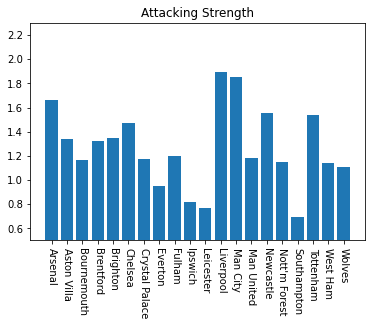

In [9]:
import matplotlib.pyplot as plt
plt.bar(x=range(20), height=PL.alpha_hat, tick_label=PL.teams)
plt.xticks(rotation=270)
plt.ylim(0.5, 2.3)
plt.title('Attacking Strength')
plt.show()

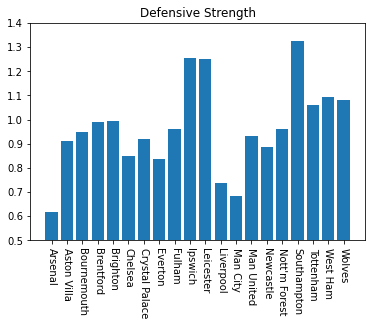

In [10]:
plt.bar(x=range(20), height=PL.beta_hat, tick_label=PL.teams)
plt.xticks(rotation=270)
plt.ylim(0.5, 1.4)
plt.title('Defensive Strength')
plt.show()

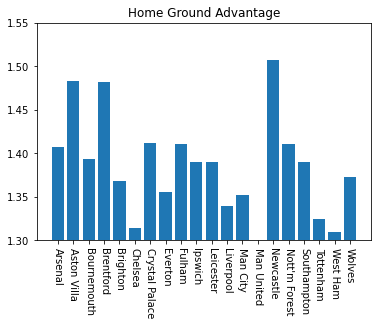

In [11]:
plt.bar(x=range(20), height=PL.gamma_hat, tick_label=PL.teams)
plt.xticks(rotation=270)
plt.ylim(1.3, 1.55)
plt.title('Home Ground Advantage')
plt.show()

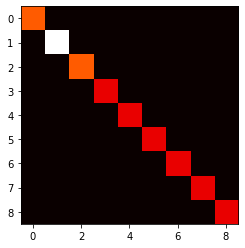

In [12]:
points_matrix = get_points_matrix(1, 1)
plt.imshow(points_matrix, cmap='hot')
plt.show()

In [13]:
PL.predict("Aston Villa", "Newcastle")

{'matrix': array([[4.15807063e-02, 5.88972799e-02, 4.17127304e-02, 1.96947621e-02,
         6.97419562e-03, 1.97572956e-03, 4.66422640e-04, 9.43810834e-05,
         1.97677133e-05],
        [7.33343146e-02, 1.03874899e-01, 7.35671605e-02, 3.47349050e-02,
         1.23001243e-02, 3.48451928e-03, 8.22611919e-04, 1.66456337e-04,
         3.48635662e-05],
        [6.46684746e-02, 9.16001096e-02, 6.48738054e-02, 3.06303173e-02,
         1.08466314e-02, 3.07275725e-03, 7.25404721e-04, 1.46786364e-04,
         3.07437747e-05],
        [3.80177787e-02, 5.38505464e-02, 3.81384900e-02, 1.80071763e-02,
         6.37659745e-03, 1.80643514e-03, 4.26456265e-04, 8.62938478e-05,
         1.80738764e-05],
        [1.67626286e-02, 2.37435416e-02, 1.68158521e-02, 7.93964346e-03,
         2.81154077e-03, 7.96485285e-04, 1.88031185e-04, 3.80482966e-05,
         7.96905260e-06],
        [5.91272245e-03, 8.37511674e-03, 5.93149611e-03, 2.80056961e-03,
         9.91721563e-04, 2.80946178e-04, 6.63246938e-05, 

In [14]:
PL.trained_data

,SEA,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,BS,PHome,...,1XBCH,1XBCD,1XBCA,BFECH,BFECD,BFECA,BFEC>2.5,BFEC<2.5,BFECAHH,BFECAHA
0,1996.0,E0,1995-08-19,Aston Villa,Man United,3,1,H,0.414300,0.474459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996.0,E0,1995-08-19,Blackburn,QPR,1,0,H,0.414300,0.474459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1996.0,E0,1995-08-19,Chelsea,Everton,0,0,D,0.833365,0.474459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996.0,E0,1995-08-19,Liverpool,Sheffield Weds,1,0,H,0.414300,0.474459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996.0,E0,1995-08-19,Man City,Tottenham,1,1,D,0.833365,0.474459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2025.0,E0,2025-05-18,Leicester,Ipswich,2,0,H,0.496734,0.424682,...,2.30,3.69,3.07,2.36,3.75,3.15,1.72,2.36,2.03,1.95
11386,2025.0,E0,2025-05-18,Arsenal,Newcastle,1,0,H,0.198999,0.636313,...,1.91,3.79,4.10,1.94,3.90,4.30,1.80,2.22,1.94,2.05
11387,2025.0,E0,2025-05-19,Brighton,Liverpool,3,2,H,0.857219,0.262551,...,2.31,3.91,2.91,2.32,4.00,3.10,1.52,2.88,2.03,1.96
11388,2025.0,E0,2025-05-20,Crystal Palace,Wolves,4,2,H,0.322937,0.536136,...,2.31,3.37,3.33,2.50,3.45,3.20,1.97,2.02,2.11,1.89


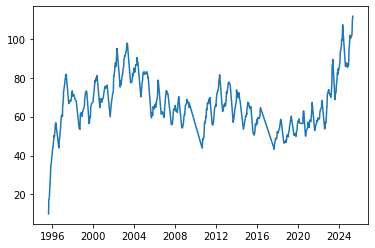

In [15]:
nufc_home = PL.trained_data[PL.trained_data['HomeTeam'] == "Newcastle"]
plt.plot(nufc_home['Date'], nufc_home['p_alpha_home'])

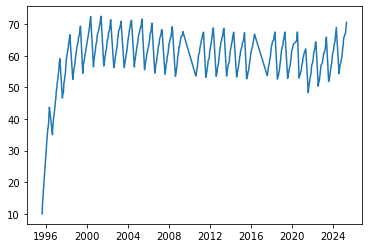

In [16]:
nufc_home = PL.trained_data[PL.trained_data['HomeTeam'] == "Newcastle"]
plt.plot(nufc_home['Date'], nufc_home['q_alpha_home'])

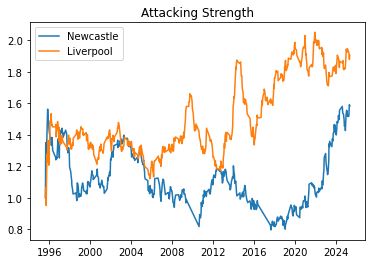

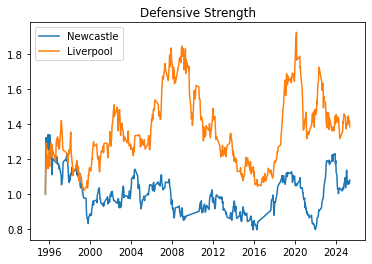

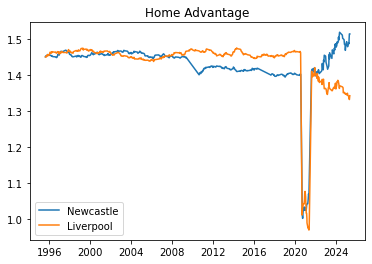

In [17]:
nufc_home = PL.trained_data[PL.trained_data['HomeTeam'] == "Newcastle"]
liv_home = PL.trained_data[PL.trained_data['HomeTeam'] == "Liverpool"]

plt.plot(nufc_home['Date'], nufc_home['p_alpha_home']/nufc_home['q_alpha_home'], label = "Newcastle")
plt.plot(liv_home['Date'], liv_home['p_alpha_home']/liv_home['q_alpha_home'], label = "Liverpool")
plt.title("Attacking Strength")
plt.legend()
plt.show()

plt.plot(nufc_home['Date'], nufc_home['q_beta_home']/nufc_home['p_beta_home'], label = "Newcastle")
plt.plot(liv_home['Date'], liv_home['q_beta_home']/liv_home['p_beta_home'], label = "Liverpool")
plt.title("Defensive Strength")
plt.legend()
plt.show()

plt.plot(nufc_home['Date'], nufc_home['p_gamma_home']/nufc_home['q_gamma_home'], label = "Newcastle")
plt.plot(liv_home['Date'], liv_home['p_gamma_home']/liv_home['q_gamma_home'], label = "Liverpool")
plt.title("Home Advantage")
plt.legend()
plt.show()